In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons,make_classification,make_circles
# from visualize import plot_decision_boundary

## Implementation of NeuralNetwork

    -Hidden layer:2 and input and output layer

In [2]:
class NeuralNetwork:
    
    def __init__(self,input_size,layers_dim,output_size):
        np.random.seed(0)
        
        models = {}  #it store the weight and bias of every layer(hiddden,input and output layer)
        
        #Input layer and bias--1st hidden layer weights
        models["W1"]=np.random.randn(input_size,layers_dim[0]) #(n X l0)
        models["b1"]=np.zeros((1,layers_dim[0]))#(1 X l0)
        
        #1stHL-2ndHL wts and bias
        models["W2"] = np.random.randn(layers_dim[0],layers_dim[1])#(l0 X l1)
        models["b2"]=np.zeros((1,layers_dim[1]))#(1 X l1)
        
        #2ndHL-output layer wts
        models["W3"] = np.random.randn(layers_dim[1],output_size)#(l1 X k)
        models["b3"]=np.zeros((1,output_size))#(1 X k)
        
        self.models=models
        self.activations_=None
        
    @staticmethod    
    def softmax(z):
        exp_z=np.exp(z)  #elementwise operation #vector
        
        return exp_z/np.sum(exp_z,axis=1,keepdims=True)
    
    def forward(self,x):
        W1 , W2 , W3 = self.models["W1"] , self.models["W2"] , self.models["W3"]
        b1 , b2 , b3 = self.models["b1"] , self.models["b2"] , self.models["b3"]
        
        Z1 = np.dot(x,W1) + b1    #(m x n) X (n X l0) -- (m X l0)
        A1 = np.tanh(Z1)
        
        Z2 = np.dot(A1,W2) + b2   #(m x l0) X (l0 X l1) -- (m X l1)
        A2 = np.tanh(Z2)
        
        Z3 = np.dot(A2,W3) + b3    #(m x l1) X (l1 X l2) -- (m X l2)
        Y_ = NeuralNetwork.softmax(Z3)
        
        self.activations_ = A1 , A2 , Y_
        
        return Y_
    
    def backward(self,x,y,alpha=0.001): #Here y is one hot vector of (m X k)
        
        W1 , W2 , W3 = self.models["W1"] , self.models["W2"] , self.models["W3"]
        b1 , b2 , b3 = self.models["b1"] , self.models["b2"] , self.models["b3"]
        
        A1 , A2 , Y_ = self.activations_
        
        
        # 1)_Gradient Calculation 
        
        #loss propagate from output layer to 2nd HL
        delta_3 = Y_ - y  #(m X k)
        dW3 = np.dot(A2.T,delta_3) #A2.T--(l1 X m) #delta_3--(m X k) #(A2.T X delta_3)--(dW3)--(l1 X k)
        db3 = np.sum(delta_3,axis=0,keepdims=True)/x.shape[0] #delta_3--(m X k) db3--(1Xk)
        
        #(1-A2^2) is derivative of tanh function 
        #loss propagate from 2nd HL to 1st HL
        delta_2 = delta_3.dot(W3.T) * (1-np.square(A2)) #((m X k) X (k X l1)) * (m Xl1))---(m X l1)
        dW2 = np.dot(A1.T,delta_2)# ((l0 X m) X (m X l1)) --- (l0 X l1)
        db2 = np.sum(delta_2,axis=0,keepdims=True)/x.shape[0] #(m X l1)---(1 X l1)
        
        #loss propagate from 1st HL to input layer 
        delta_1 = delta_2.dot(W2.T) * (1-np.square(A1)) #( ((m X l1) X (l1 X l0)) * (m X l0) ) --- (m X l0)
        dW1 = np.dot(x.T,delta_1) #( (n X m) X (m X l0) ) --- (n X l0)
        db1 = np.sum(delta_1,axis=0,keepdims=True)/x.shape[0] #(m X l0) --- (1 X l0)
        
        # 2)_Update Weights
        
        self.models["W1"] -= alpha * dW1
        self.models["W2"] -= alpha * dW2
        self.models["W3"] -= alpha * dW3
        
        self.models["b1"] -= alpha * db1
        self.models["b2"] -= alpha * db2
        self.models["b3"] -= alpha * db3
        
    def predict(self,x):
        
        return np.argmax(self.forward(x),axis=1)
    
    @staticmethod
    def loss(y_label,y_predict):#y_label is one hot vector means only one idx is 1(repr. class)
                                 # and other is 0 -----Categorical Cross Entropy E(m example)
        return -np.mean(y_label*np.log(y_predict)) #np.sum and np.mean both are right
    
    @staticmethod
    def one_hot_vector(y,k):#k=len(Unique class)
        
        y_ohv=np.zeros((y.shape[0],k))
        y_ohv[np.arange(y.shape[0]),y]=1
        
        return y_ohv
    
    def fit(self,X,Y,alpha=0.001,epoch=50):
        
        losses=[]
        
        # 1)-Create the one hot vector
        
        k=len(np.unique(Y))
        y_ohv=NeuralNetwork.one_hot_vector(Y,k)
        
        #2)-Calculate loss of every forward propagate and backpropagate the loss 
        
        for i in range(epoch):
            y_ = self.forward(X)
            l = NeuralNetwork.loss(y_ohv,y_)
            losses.append(l)
            self.backward(X,y_ohv,alpha)
            
            #3)print the loss of every 5 epoch
            
            if i%5==0:
                print("{} epoch --> Loss is {} ".format(i,l))
    
        
        return losses

    def accuracy(self,X,Y):
        pred=self.predict(X)
        return np.sum(Y==pred)/X.shape[0]
    
    def summary(self):
        W1,W2,W3 = self.models['W1'],self.models['W2'],self.models['W3']
        a1,a2,y_ = self.activations_
    
        print("W1 ",W1.shape)
        print("A1 ",a1.shape)
        
        print("W2 ",W2.shape)
        print("A2 ",a2.shape)
        
        print("W3 ",W3.shape)
        print("Y_ ",y_.shape)
        

## DatasetPreparation

In [3]:
def Dataset_prep(dataset):
    if dataset == "moon": #sample has only two unique class
        X,Y=make_moons(n_samples=500,noise=0.2,random_state=1)
        
    elif dataset == "circles": #sample has k=2
        X,Y=make_circles(n_samples=500,noise=0.2,random_state=1,factor=0.4)
        
    elif dataset == "classification":
        X,Y=make_classification(n_samples=500,n_features=2,n_redundant=0,random_state=1)
        
    else:
        
        #xor dataset
        X = np.array([[0,0],
                    [0,1],
                    [1,0],
                    [1,1]])
        Y = np.array([0,1,1,0])
        
    return X,Y
        

In [4]:
dataset=["moon","circles","xor","classification"]

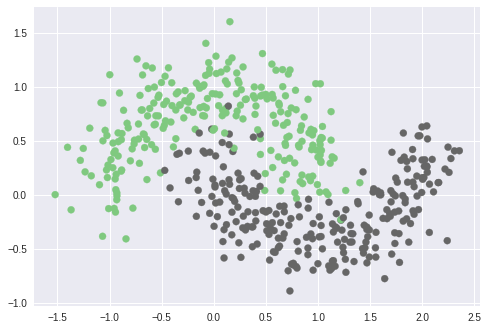

-------------------------Dataset --> moon--------------------------- 
0 epoch --> Loss is 0.35532194744781637 
5 epoch --> Loss is 0.2546145065622971 
10 epoch --> Loss is 0.2849762266164188 
15 epoch --> Loss is 0.18591430854697671 
20 epoch --> Loss is 0.16927012180597883 
25 epoch --> Loss is 0.17673213097575363 
30 epoch --> Loss is 0.19387287362359798 
35 epoch --> Loss is 0.15814270584070209 
40 epoch --> Loss is 0.17856547600104744 
45 epoch --> Loss is 0.1460667495901356 
----------------Loss graph----------------------


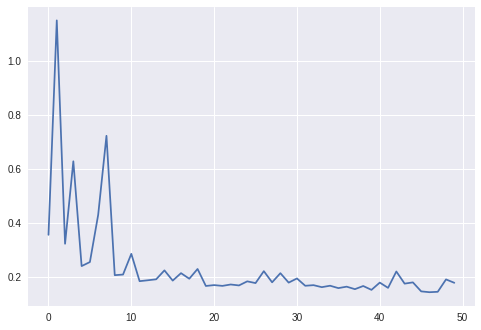


Training Accuracy :: 0.818 


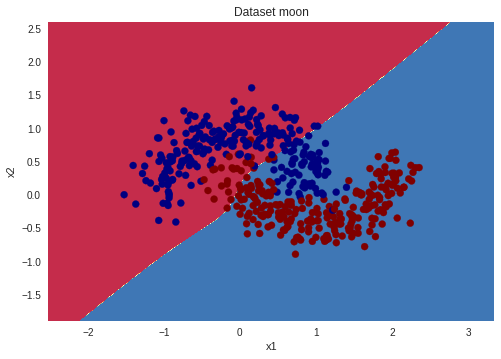

----------------------------------END----------------------------------------------------





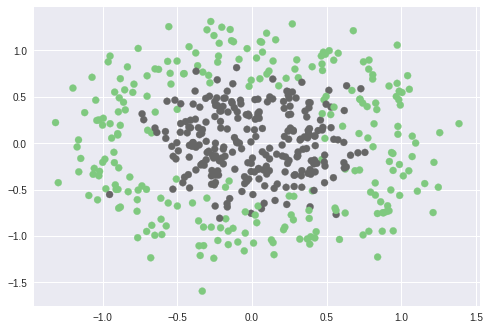

-------------------------Dataset --> circles--------------------------- 
0 epoch --> Loss is 0.8073486397892449 
5 epoch --> Loss is 1.686969041158179 
10 epoch --> Loss is 0.4557957424745766 
15 epoch --> Loss is 0.4040498189595403 
20 epoch --> Loss is 0.8647398818479066 
25 epoch --> Loss is 1.3276862311652977 
30 epoch --> Loss is 0.9855325375265304 
35 epoch --> Loss is 0.3707149476266732 
40 epoch --> Loss is 0.4956069302943151 
45 epoch --> Loss is 0.8949961590158739 
----------------Loss graph----------------------


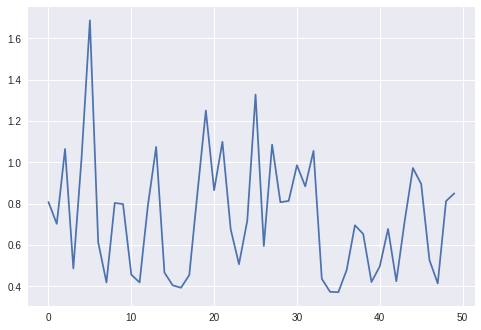


Training Accuracy :: 0.49 


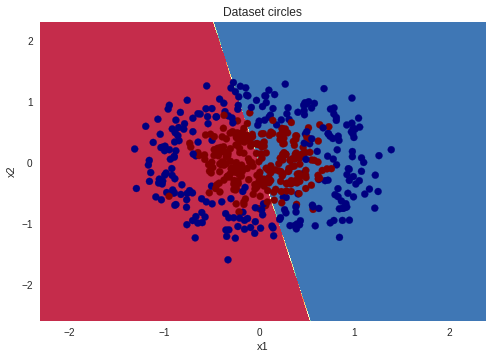

----------------------------------END----------------------------------------------------





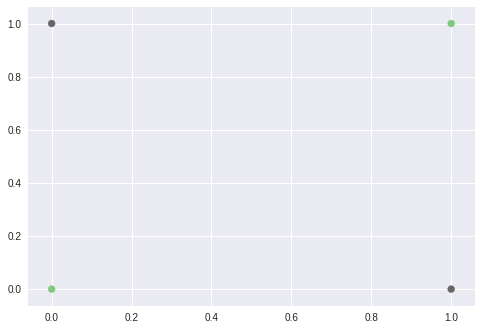

-------------------------Dataset --> xor--------------------------- 
0 epoch --> Loss is 0.9560439241527451 
5 epoch --> Loss is 0.6791738063873829 
10 epoch --> Loss is 0.5362643792254254 
15 epoch --> Loss is 0.4489394490288232 
20 epoch --> Loss is 0.3868126375431632 
25 epoch --> Loss is 0.3421615938936884 
30 epoch --> Loss is 0.3088810621528099 
35 epoch --> Loss is 0.2825049273590645 
40 epoch --> Loss is 0.2603887503729575 
45 epoch --> Loss is 0.24107094120302758 
----------------Loss graph----------------------


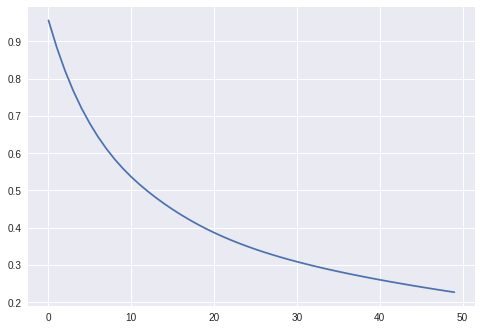


Training Accuracy :: 1.0 


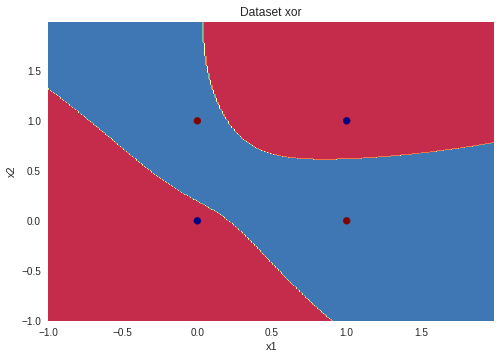

----------------------------------END----------------------------------------------------





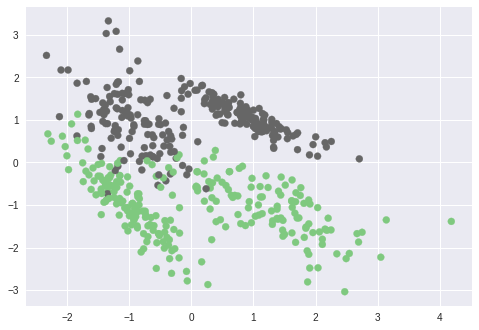

-------------------------Dataset --> classification--------------------------- 
0 epoch --> Loss is 1.8244302909206378 
5 epoch --> Loss is 0.41906482146826546 
10 epoch --> Loss is 0.13512905681261783 
15 epoch --> Loss is 0.11024819723901869 
20 epoch --> Loss is 0.10689824286620762 
25 epoch --> Loss is 0.10498473127315493 
30 epoch --> Loss is 0.1031535614162976 
35 epoch --> Loss is 0.10091671565247125 
40 epoch --> Loss is 0.0983189390090342 
45 epoch --> Loss is 0.09611286526086936 
----------------Loss graph----------------------


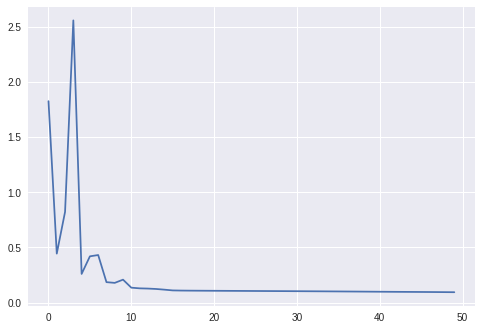


Training Accuracy :: 0.942 


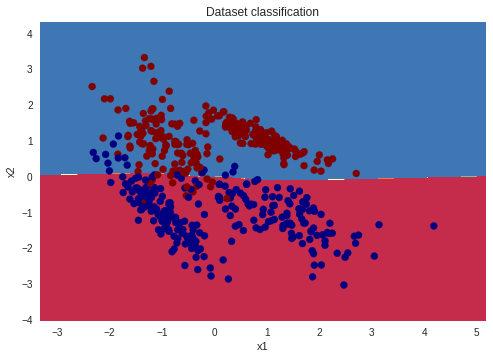

----------------------------------END----------------------------------------------------





In [9]:
for data in dataset:
    model=NeuralNetwork(input_size=2,layers_dim=[4,3],output_size=2)
    X,Y = Dataset_prep(data)
#     print("----------------------------------START----------------------------------------------------")
    plt.style.use("seaborn")
    plt.scatter(X[:,0],X[:,1],c=Y,cmap=plt.cm.Accent)
    plt.show()
    print("-------------------------Dataset --> {}--------------------------- ".format(data))
    losses=model.fit(X,Y,alpha=0.01)
    p=model.accuracy(X,Y)
    print("----------------Loss graph----------------------")
    plt.plot(losses)
    plt.show()
    print("\nTraining Accuracy :: {} ".format(p))
    
    plt.title("Dataset "+data)
    plot_decision_boundary(lambda x :model.predict(x),X,Y)
    plt.show()
    print("----------------------------------END----------------------------------------------------")
    print("\n\n")

In [6]:
!git add Implementation_NNScratch.ipynb

In [7]:
!git commit -m"NN 2 hidden layer"

On branch master
Your branch is ahead of 'origin/master' by 1 commit.
  (use "git push" to publish your local commits)

Changes not staged for commit:
	modified:   .ipynb_checkpoints/Implementation_NNScratch-checkpoint.ipynb
	modified:   ../PerceptronModel/LinearClassifier.ipynb

no changes added to commit


In [8]:
def plot_decision_boundary(model, X, Y,cmap=plt.cm.jet):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    m, n = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[m.ravel(), n.ravel()]) #np.c_ (it take 1st list axis 0 dim and other list dim axis=1(add all))
    Z = Z.reshape(m.shape)
    # Plot the contour it act as front or refrence of our point of dataset
    plt.contourf(m, n, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.style.use("seaborn")
    plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.jet) #plot all point of constructed contour
    